# 2) Solens upp- och nedgång 
Modul 2: linjära ekvationssystem och Modul 3: Kurvanpassning

Tabell 1 innehåller medelvärdet i minuter som solen är uppe i Stockholm under årets tolv månader.

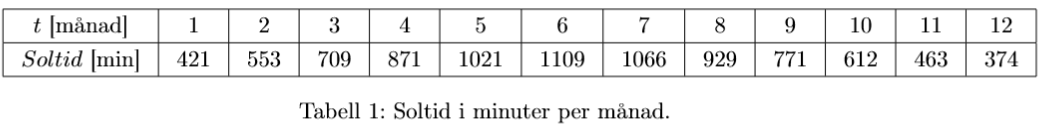

I denna uppgift ska du skriva ett Python-program som gör kurvanpassningarna i uppgifterna
a), c)-e) till data i tabellen.

För varje kurvanpassning:

•plotta den anpassade modellen tillsammans med data från tabellen,

•beräkna minstakvadratfelet (i kvadrat),

•du **får** använda den inbyggda functionen numpy.vander i uppgift a) men du **får inte**
använda följande Python-funktioner: numpy.polyfit; numpy.polyval,

•du **får inte** använda den inbyggda funtionen scipy.optimize.curve_fit i uppgift c till
e).

## 2.a) 

Modell: ett interpolationspolynom till alla data.

Vilket gradtal blir det på polynomet?

Beräkna interpolationspolynomet på tre olika sätt:

•Naiv ansats: p1(t) = c0 + c1t + c2t2 + ···

•Centrerad ansats: p2(t) = c0 + c1(t −tm) + c2(t −tm)2 ···, där tm är medelvärdet
i tidsvektorn t = [1 2 ···12]T .

•Newtons ansats: p3(t) = c0 + c1(t−t1) + c2(t−t1)(t−t2) ···, där t1 är komponent
1 i tidsvektorn t osv.

Evaluera polynomen p1,p2,p3 i 1000 punkter mellan 0 och 12 och räkna ut maximala
skillnaden på intervallet mellan p1,p2,p3. 

Du behöver bara plotta polynomet för en av
ansatserna ovan. 

Varför?

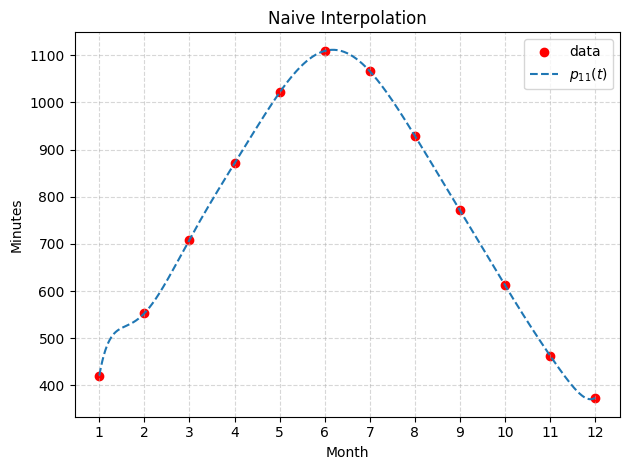

With naive ansatz p(x) has SSE = 9.656598722179142e-14
With centered ansatz p(x) has SSE = 5.0884532369082343e-23
With Newton ansatz p(x) has SSE = 1.0985992510469899e-24


Condition number for naive method is 1.1605354618836394e+16
Condition number for centered method is 495102791.73094493
Condition number for newton method is 217010224.00010672


In [ ]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from typing import Callable, Optional

plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "dashed"
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["legend.fancybox"] = True


data: list = [
    421,
    553,
    709,
    871,
    1021,
    1109,
    1066,
    929,
    771,
    612,
    463,
    374,
]  # mins of sun / month

sun_data: np.ndarray = np.array(data)
t = np.linspace(1, 12, 12)
t_dense = np.linspace(1, 12, 1000)


def plot_model(
    t_data: np.ndarray,
    y_data: np.ndarray,
    model: Callable[[np.ndarray], np.ndarray],
    t_plot: Optional[np.ndarray] = None,
    title: str = "",
    model_label: str = "model",
    data_label: str = "data",
) -> None:
    t_data = np.asarray(t_data)
    y_data = np.asarray(y_data)

    if t_plot is None:
        t_plot = np.linspace(t_data.min(), t_data.max(), 400)

    fig, ax = plt.subplots()
    ax.scatter(t_data, y_data, color="red", label=data_label)
    ax.plot(t_plot, model(t_plot), linestyle="dashed", label=model_label)
    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Minutes")
    ax.set_xticks(t_data)
    ax.legend(loc="best")
    fig.tight_layout()
    plt.show()


def SSE(residuals: np.ndarray) -> float:
    """
    Compute the sum of squared errors (SSE) for a set of residuals.

    Given residuals r_i = y_i - ŷ_i from a curve fit or regression model,
    this function returns

        SSE = sum_i r_i^2,

    which is the unnormalized least-squares error often used to quantify
    the total discrepancy between data and model. The input may be a
    1D array of length n or an (n, 1) column vector; it is flattened
    internally before computation.

    Args:
        residuals (np.ndarray):
            Array of residuals r_i = y_i - ŷ_i, shape (n,) or (n, 1).

    Returns:
        float:
            Sum of squared errors, SSE = Σ r_i^2.
    """
    sse = float(np.transpose(residuals) @ residuals)
    return sse


# Naive Interpolation
A_naive = np.vander(t, increasing=True)
c_naive = np.linalg.solve(A_naive, sun_data)
p_naive = poly.Polynomial(c_naive)
y_naive = p_naive(t)
residual_naive = sun_data - y_naive
naive_sse = SSE(residual_naive)

plot_model(
    t_data=t,
    y_data=sun_data,
    model=p_naive,
    t_plot=t_dense,
    title="Naive Interpolation",
    model_label=r"$p_{11}(t)$",
)

print(
    f"With naive ansatz p(x) has SSE = {naive_sse}"
)

# Centered ansatz
t_m = np.mean(t)
tau = t - t_m
tau_dense = t_dense - t_m
A_centered = np.vander(tau, increasing=True)
c_centered = np.linalg.solve(A_centered, sun_data)
p_centered = poly.Polynomial(c_centered)
y_centered = p_centered(tau)
residual_centered = sun_data - y_centered
centered_sse = SSE(residual_centered)


# def centered_model(t):
#     return p_centered(t - t_m)

# plot_model(
#     t_data=t,
#     y_data=sun_data,
#     model=centered_model,
#     t_plot=t_dense,
#     title="Centered Interpolation",
#     model_label=r"$p_{11}(\tau), \tau = t- t_m$",
#

print(f"With centered ansatz p(x) has SSE = {centered_sse}")


# Newton ansatz
def divided_differences(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Compute Newton's divided-difference coefficients for polynomial interpolation.

    Given data points (x_i, y_i), i = 0, ..., n-1, this function computes the
    coefficients c_0, ..., c_{n-1} of the Newton form of the interpolating
    polynomial

        p(x) = c_0
             + c_1 (x - x_0)
             + c_2 (x - x_0)(x - x_1)
             + ...
             + c_{n-1} (x - x_0)...(x - x_{n-2}).

    The coefficients are returned in a 1D array `coefficients` such that
    `coefficients[k] = c_k`.

    Args:
        x (np.ndarray): 1D array of distinct x-values (nodes), shape (n,).
        y (np.ndarray): 1D array of function values y_i = f(x_i), shape (n,).

    Returns:
        np.ndarray: 1D array of length n containing the divided-difference
        coefficients for the Newton interpolating polynomial.

    Raises:
        ValueError: If x and y do not have the same shape or if fewer than
        two data points are provided.
    """
    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape")
    if x.ndim != 1:
        raise ValueError("x and y must be 1D arrays")
    if len(x) < 2:
        raise ValueError("At least two data points are required")

    n: int = len(x)
    coefficients = np.array(y, dtype=float)

    for j in range(1, n):
        coefficients[j:n] = (coefficients[j:n] - coefficients[j - 1 : n - 1]) / (
            x[j:n] - x[0 : n - j]
        )

    return coefficients


def newton_interpolation_matrix(x: np.ndarray) -> np.ndarray:
    """
    Build the Newton interpolation basis matrix for given nodes x.

    Given nodes x = (x_0, ..., x_{n-1}), this function constructs the n x n
    matrix N such that column j contains the values of the j-th Newton basis
    polynomial

        phi_0(t) = 1
        phi_1(t) = (t - x_0)
        phi_2(t) = (t - x_0)(t - x_1)
        ...
        phi_{n-1}(t) = (t - x_0)...(t - x_{n-2}),

    evaluated at t = x_i. In other words,

        N[i, 0] = 1
        N[i, 1] = (x_i - x_0)
        N[i, 2] = (x_i - x_0)(x_i - x_1)
        ...
        N[i, j] = prod_{k=0}^{j-1} (x_i - x_k).

    This matrix can be used together with the divided-difference coefficients c
    to evaluate the interpolating polynomial at the nodes via N @ c.

    Args:
        x (np.ndarray): 1D array of interpolation nodes, shape (n,).

    Returns:
        np.ndarray: 2D array of shape (n, n) where column j contains the
        j-th Newton basis evaluated at the nodes x.

    Raises:
        ValueError: If x is not a 1D array.
    """

    if x.size == 0:
        raise ValueError("x is empty")

    if x.ndim != 1:
        raise ValueError("x must be a 1D array")

    n: int = x.size
    matrix = np.zeros((n, n), dtype=float)
    matrix[:, 0] = 1.0  # first column is all ones

    for j in range(1, n):
        for i in range(j, n):
            matrix[i, j] = matrix[i, j - 1] * (x[i] - x[j - 1])

    return matrix


c_newton = divided_differences(t, sun_data)
A_newton = newton_interpolation_matrix(t)
y_newton = A_newton @ c_newton
residual_newton = sun_data - y_newton
sse_newton = SSE(residual_newton)
print(f"With Newton ansatz p(x) has SSE = {sse_newton}")

# Calc maxnorm condition numbers
k_naive = np.linalg.cond(A_naive, p=np.inf)
k_centered = np.linalg.cond(A_centered, p=np.inf)
k_newton = np.linalg.cond(A_newton, p=np.inf)

print('\n')
print(f'Condition number for naive ansatz is {k_naive}')
print(f'Condition number for centered ansatz is {k_centered}')
print(f'Condition number for newton ansatz is {k_newton}')



### Answer 2.a)
With naive ansatz p(x) has SSE = 9.656598722179142e-14
With centered ansatz p(x) has SSE = 5.0884532369082343e-23
With Newton ansatz p(x) has SSE = 1.0985992510469899e-24

All the different methods produce the same polynomial since for a set number of points there is one *unique* interpolating polynomial of highest degree n-1 that passes through all n points. That is to say, each method produces the same polynomial, they just express it in a different basis in the space of polynomials.
___
### Answer 2.b)
Condition number for naive method is 1.1605354618836394e+16
Condition number for centered method is 495102791.73094493
Condition number for newton method is 217010224.00010672

Which shows that the naive method is poorly conditioned (large numbers) while the newton method has the best balance, i.e noise in the input data will get amplified much more while using the naive method. Centering reduces that by a large factor while newtons ansatz amplifies the error the least of the three.
